In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import pandas as pd

In [2]:
from keras.layers import Input, Embedding, merge, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam

Using Theano backend.


In [3]:
path = '/home/matar/courses-master/deeplearning1/nbs/data/movielens-small/'
model_path = '/home/matar/courses-master/deeplearning1/nbs/models/'

# Setup your data

In [4]:
#read the data and prepare them
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

In [7]:
pd.read_csv(path+'movies.csv')[:5]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
pd.read_csv(path+'movies.csv').set_index('movieId')['title'][:5]

movieId
1                      Toy Story (1995)
2                        Jumanji (1995)
3               Grumpier Old Men (1995)
4              Waiting to Exhale (1995)
5    Father of the Bride Part II (1995)
Name: title, dtype: object

In [12]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [13]:
users  = ratings.userId.unique()
movies = ratings.movieId.unique()

users_num  = ratings.userId.nunique()
movies_num = ratings.movieId.nunique()
users_num, movies_num

(671, 9066)

In [18]:
#assign contigous ids to users and movies to avoid any out-of-boundary errors
useridtoidx = {o:i for i,o in enumerate (users)}
movieidtoidx= {o:i for i,o in enumerate (movies)}

ratings.userId = ratings.userId.apply(lambda x:useridtoidx[x])
ratings.movieId = ratings.movieId.apply(lambda x:movieidtoidx[x])

In [19]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [20]:
lf_num = 50 #number of latent factors

In [21]:
#split training and validation set at random
msk = np.random.rand(len(ratings))<0.8 #create an array of random booleans of same number of ratings
trn = ratings[msk]
val= ratings[~msk]
len(trn), len(val)

(80088, 19916)

This is better than doing sth like below, because it shuffle the data. However, the drawback of the previous approach is that sizes of validation and training sets are not guaranteed (the validation might be larger!!)

    train_size = 0.8

    trn = ratings[:int(len(ratings)*train_size)]

    val = ratings[int(len(ratings)*train_size):]

In [22]:
#format the inputs as embeddings
def create_embedding(in_num, out_num, input_shape, name, inp=None):
    if (inp == None):
        inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(in_num, out_num, input_length=input_shape, W_regularizer=l2(1e-4))(inp)

ui, ue = create_embedding(users_num, lf_num, 1, 'ue')
mi, me = create_embedding(movies_num, lf_num,1, 'me')

#create biases
ubi, ub = create_embedding(users_num, out_num=1, input_shape=1, name='ub', inp = ui)
umi, mb = create_embedding(movies_num, out_num=1, input_shape=1, name='mb', inp = mi)

ub = Flatten()(ub)
mb = Flatten()(mb)

/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  """
/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 50, embeddings_regularizer=<keras.reg..., input_length=1)`
  """
/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(671, 1, embeddings_regularizer=<keras.reg..., input_length=1)`
  """
/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(9066, 1, embeddings_regularizer=<keras.reg..., input_length=1)`
  """


In [23]:
#A simple bias model (we dot multiply the latent factors of users by those of movies and add bias terms)
x = merge([ue,me], mode='dot')
x = Flatten()(x)
x = merge ([x, ub], mode='sum')
x = merge ([x, mb], mode='sum')

model = Model([ui, mi], x)
model.compile(Adam(0.001), loss='mse')

/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/home/matar/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.
/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [24]:
#simple training routine
def train(nb_epoch = 1, lr=0.001):
    model.optimizer.lr= lr
    model.fit([trn.userId, trn.movieId], trn.rating, nb_epoch = nb_epoch, 
          validation_data=([val.userId, val.movieId], val.rating))

In [14]:
train(nb_epoch=3, lr=0.001)

/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 80192 samples, validate on 19812 samples
Epoch 1/3
80192/80192 [==============================] - 25s - loss: 7.0993 - val_loss: 2.7889
Epoch 2/3
80192/80192 [==============================] - 21s - loss: 2.2601 - val_loss: 2.1600
Epoch 3/3
80192/80192 [==============================] - 21s - loss: 1.9365 - val_loss: 2.0332


In [18]:
train(nb_epoch=10, lr=0.1)

Train on 80192 samples, validate on 19812 samples
Epoch 1/10
  640/80192 [..............................] - ETA: 21s - loss: 1.7223

/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


80192/80192 [==============================] - 21s - loss: 1.8263 - val_loss: 1.9551
Epoch 2/10
80192/80192 [==============================] - 21s - loss: 1.7446 - val_loss: 1.8876
Epoch 3/10
80192/80192 [==============================] - 21s - loss: 1.6772 - val_loss: 1.8296
Epoch 4/10
80192/80192 [==============================] - 21s - loss: 1.6163 - val_loss: 1.7882
Epoch 5/10
80192/80192 [==============================] - 21s - loss: 1.5602 - val_loss: 1.7528
Epoch 6/10
80192/80192 [==============================] - 21s - loss: 1.5128 - val_loss: 1.7261
Epoch 7/10
80192/80192 [==============================] - 21s - loss: 1.4696 - val_loss: 1.6999
Epoch 8/10
80192/80192 [==============================] - 21s - loss: 1.4303 - val_loss: 1.6815
Epoch 9/10
80192/80192 [==============================] - 21s - loss: 1.3972 - val_loss: 1.6686
Epoch 10/10
80192/80192 [==============================] - 22s - loss: 1.3680 - val_loss: 1.6601


In [19]:
train(nb_epoch=5, lr=0.001)

Train on 80192 samples, validate on 19812 samples
Epoch 1/5
  640/80192 [..............................] - ETA: 21s - loss: 1.2772

/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


80192/80192 [==============================] - 22s - loss: 1.3420 - val_loss: 1.6506
Epoch 2/5
80192/80192 [==============================] - 22s - loss: 1.3191 - val_loss: 1.6460
Epoch 3/5
80192/80192 [==============================] - 22s - loss: 1.3008 - val_loss: 1.6466
Epoch 4/5
80192/80192 [==============================] - 22s - loss: 1.2853 - val_loss: 1.6399
Epoch 5/5
80192/80192 [==============================] - 22s - loss: 1.2715 - val_loss: 1.6413


# Try a simple nueral network based model instead

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [25]:
#our nueral net model
x = merge([ue,me], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(1)(x)

model = Model([ui, mi], x)
model.compile(Adam(0.001), loss='mse')

/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [26]:
train(nb_epoch=5)

/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 80088 samples, validate on 19916 samples
Epoch 1/5
80088/80088 [==============================] - 50s - loss: 2.0445 - val_loss: 1.0218
Epoch 2/5
80088/80088 [==============================] - 51s - loss: 1.1918 - val_loss: 0.8715
Epoch 3/5
80088/80088 [==============================] - 43s - loss: 0.9360 - val_loss: 0.8576
Epoch 4/5
80088/80088 [==============================] - 40s - loss: 0.8701 - val_loss: 0.8710
Epoch 5/5
80088/80088 [==============================] - 41s - loss: 0.8523 - val_loss: 0.8622


In [22]:
train(nb_epoch=10, lr=0.1)

Train on 80192 samples, validate on 19812 samples
Epoch 1/10
  288/80192 [..............................] - ETA: 56s - loss: 0.7020

/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


80192/80192 [==============================] - 51s - loss: 0.8613 - val_loss: 0.8572
Epoch 2/10
80192/80192 [==============================] - 52s - loss: 0.8477 - val_loss: 0.8542
Epoch 3/10
80192/80192 [==============================] - 57s - loss: 0.8371 - val_loss: 0.8499
Epoch 4/10
80192/80192 [==============================] - 53s - loss: 0.8288 - val_loss: 0.8456
Epoch 5/10
80192/80192 [==============================] - 58s - loss: 0.8241 - val_loss: 0.8458
Epoch 6/10
80192/80192 [==============================] - 47s - loss: 0.8178 - val_loss: 0.8517
Epoch 7/10
80192/80192 [==============================] - 43s - loss: 0.8139 - val_loss: 0.8535
Epoch 8/10
80192/80192 [==============================] - 41s - loss: 0.8101 - val_loss: 0.8500
Epoch 9/10
80192/80192 [==============================] - 44s - loss: 0.8094 - val_loss: 0.8532
Epoch 10/10
80192/80192 [==============================] - 46s - loss: 0.8076 - val_loss: 0.8524


In [23]:
train(nb_epoch=5, lr=0.001)

Train on 80192 samples, validate on 19812 samples
Epoch 1/5
  352/80192 [..............................] - ETA: 43s - loss: 0.7306

/home/matar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


80192/80192 [==============================] - 44s - loss: 0.8074 - val_loss: 0.8608s
Epoch 2/5
80192/80192 [==============================] - 48s - loss: 0.8035 - val_loss: 0.8561
Epoch 3/5
80192/80192 [==============================] - 49s - loss: 0.8005 - val_loss: 0.8556
Epoch 4/5
80192/80192 [==============================] - 47s - loss: 0.7985 - val_loss: 0.8601
Epoch 5/5
80192/80192 [==============================] - 50s - loss: 0.8002 - val_loss: 0.8619


As expected it easly outperforms the previous model and beats the best known [academic benchmarks](http://www.librec.net/example.html) which are a bit over 0.9

# Using our model to predict

In [27]:
model.save_weights(model_path+'movielens_recommender_sys.h5')

In [28]:
model.load_weights(model_path+'movielens_recommender_sys.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, the following predicts that user #3 would really enjoy movie #5.

In [29]:
user_id = 3; movie_id = 5
p = model.predict([np.array([user_id]), np.array([movie_id])])
print ('User %d would likely rate movie \'%s\' at %f'%(user_id, movie_names[movies[movie_id]], p))

User 3 would likely rate movie 'Deer Hunter, The (1978)' at 4.351661


# Analyzing Results

## looking at the bias term

In [28]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:2000] #get the top 2000 so that it is easier for us to analyze
topMovies = np.array(topMovies.index)

In [29]:
get_movie_bias = Model(mi, mb) # a simple model that takes movie index and returns the movie bias
movie_bias = get_movie_bias.predict(topMovies) #get the biases
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)] #combine the movie bias and movie name

In [30]:
sorted(movie_ratings)[:5] #-> lowest rated movies

[(-0.22953305, 'Battlefield Earth (2000)'),
 (-0.13710555, 'Super Mario Bros. (1993)'),
 (-0.13032503, 'Little Nicky (2000)'),
 (-0.10136954, 'Scary Movie 2 (2001)'),
 (-0.085991912, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)')]

In [31]:
sorted(movie_ratings, reverse=True)[:5] # -> top rated movies

[(1.0688884, 'Shawshank Redemption, The (1994)'),
 (1.020435, 'Fugitive, The (1993)'),
 (0.93310523, 'Silence of the Lambs, The (1991)'),
 (0.91891009, 'Pulp Fiction (1994)'),
 (0.88761753, 'Godfather, The (1972)')]

## Understanding the latent factors

### trying to interpret the latent factors -> what are the factors based on which people rate movies?

In [32]:
get_movie_embedding = Model(mi, me)
movie_embeddings = np.squeeze(get_movie_embedding.predict([topMovies]))
movie_embeddings.shape

(2000, 50)

use PCA to squash these 50 factors down to only 3 (so that it is easier to inerpret), this is done by combining the factors that behave kinda in the same direction together.

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_embeddings.T).components_
movie_pca.shape

(3, 2000)

In [36]:
fact1 = movie_pca[0]
factor1 = [(f, movie_names[movies[i]]) for f, i in zip(fact1, topMovies)]
sorted(factor1, reverse=True)[:10]

[(0.060527424838257154, 'Wild Wild West (1999)'),
 (0.058399722213945481, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.052416746818551928, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.051159813277119083, 'Battlefield Earth (2000)'),
 (0.050977819871028382, 'Howard the Duck (1986)'),
 (0.050742954427490036, 'Speed 2: Cruise Control (1997)'),
 (0.050071760897559457, 'G.I. Jane (1997)'),
 (0.048054175571709566, 'Lost in Space (1998)'),
 (0.047639674966586831, 'Jurassic Park III (2001)'),
 (0.047546253191771685, 'Showgirls (1995)')]

In [37]:
sorted(factor1, reverse= False)[:10]

[(-0.073756179814619363, 'Memento (2000)'),
 (-0.072924745433108687, 'Usual Suspects, The (1995)'),
 (-0.069642176974589812, 'Shawshank Redemption, The (1994)'),
 (-0.065704004802144861, 'Pulp Fiction (1994)'),
 (-0.064069641702158411, 'Fargo (1996)'),
 (-0.063697076866840757, 'Casablanca (1942)'),
 (-0.063635463347652521, 'Monty Python and the Holy Grail (1975)'),
 (-0.063472206392887087, 'Godfather: Part II, The (1974)'),
 (-0.06037905399113918, 'Princess Bride, The (1987)'),
 (-0.060131669967330707, 'Star Wars: Episode IV - A New Hope (1977)')]

^ The first factor based on which people tend to rate movies is whether it is classic or not

In [38]:
fact2 = movie_pca[1]
factor2 = [(f,movie_names[movies[i]]) for f,i in zip(fact2, topMovies)]
sorted(factor2, reverse=True)[:10]

[(0.063183393525051673, '8 1/2 (8\xc2\xbd) (1963)'),
 (0.053587200317863702, 'General, The (1926)'),
 (0.052186968950037313, 'M (1931)'),
 (0.051228033396616551, 'Vertigo (1958)'),
 (0.049307616504424751, 'Super Mario Bros. (1993)'),
 (0.049015109983376284, 'Streetcar Named Desire, A (1951)'),
 (0.046775468623951467, "Rosemary's Baby (1968)"),
 (0.045534175553023033, 'Craft, The (1996)'),
 (0.045452344901018786, 'Ed Wood (1994)'),
 (0.045386666265031621, 'Remains of the Day, The (1993)')]

In [39]:
sorted(factor2, reverse=False)[:10]

[(-0.084076686023419334, 'Star Trek VI: The Undiscovered Country (1991)'),
 (-0.075033621679306384,
  'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.068877812440635386, 'Star Trek IV: The Voyage Home (1986)'),
 (-0.067926156035126417, 'Braveheart (1995)'),
 (-0.065159827801679004, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.065030249738692203, 'Jurassic Park (1993)'),
 (-0.064655661765473008, 'Transformers (2007)'),
 (-0.064479880987369981, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.063287034774391043, 'Monsters, Inc. (2001)'),
 (-0.062741262958772345, 'My Big Fat Greek Wedding (2002)')]

^ The second factor based on which people tend to rate movies is whether it has heavy edits or it is mostly dialogue

In [40]:
fact3 = movie_pca[2]
factor3 = [(f, movie_names[movies[i]]) for f,i in zip(fact3, topMovies)] 
sorted(factor3, reverse=True)[:10]

[(0.064225067838446781, 'Serenity (2005)'),
 (0.063206474212170127, 'Blind Side, The  (2009)'),
 (0.063027320910372983, 'Fugitive, The (1993)'),
 (0.06285685239666379, 'Seabiscuit (2003)'),
 (0.061987083195993914, 'Four Rooms (1995)'),
 (0.061831931430391965, 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)'),
 (0.059988709146684069, 'Italian Job, The (2003)'),
 (0.059386534630343671, 'Intouchables (2011)'),
 (0.0593522534538607, 'Lilo & Stitch (2002)'),
 (0.05868621108514406, 'Bourne Ultimatum, The (2007)')]

In [41]:
sorted(factor3, reverse=False)[:10]

[(-0.077737571375821518, 'Beetlejuice (1988)'),
 (-0.06961951091760811,
  'Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006)'),
 (-0.069477429064769905, 'Police Academy (1984)'),
 (-0.069441443329179842, 'Batman Returns (1992)'),
 (-0.067765275423019869, 'Mars Attacks! (1996)'),
 (-0.063388321271390435, "National Lampoon's Vacation (1983)"),
 (-0.062608426380981422, 'Abyss, The (1989)'),
 (-0.062101104803314447, 'Ring, The (2002)'),
 (-0.06135599707188464, 'Beavis and Butt-Head Do America (1996)'),
 (-0.060425147435632355, 'Fly, The (1986)')]

^ The third factor based on which people tend to rate movies is whether it is violent or happy movie

### We can visualize those factors for further analysis by plotting them in higher dimensionality. For example, let's draw apicture of the first and second factors on x,y axes

In [42]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

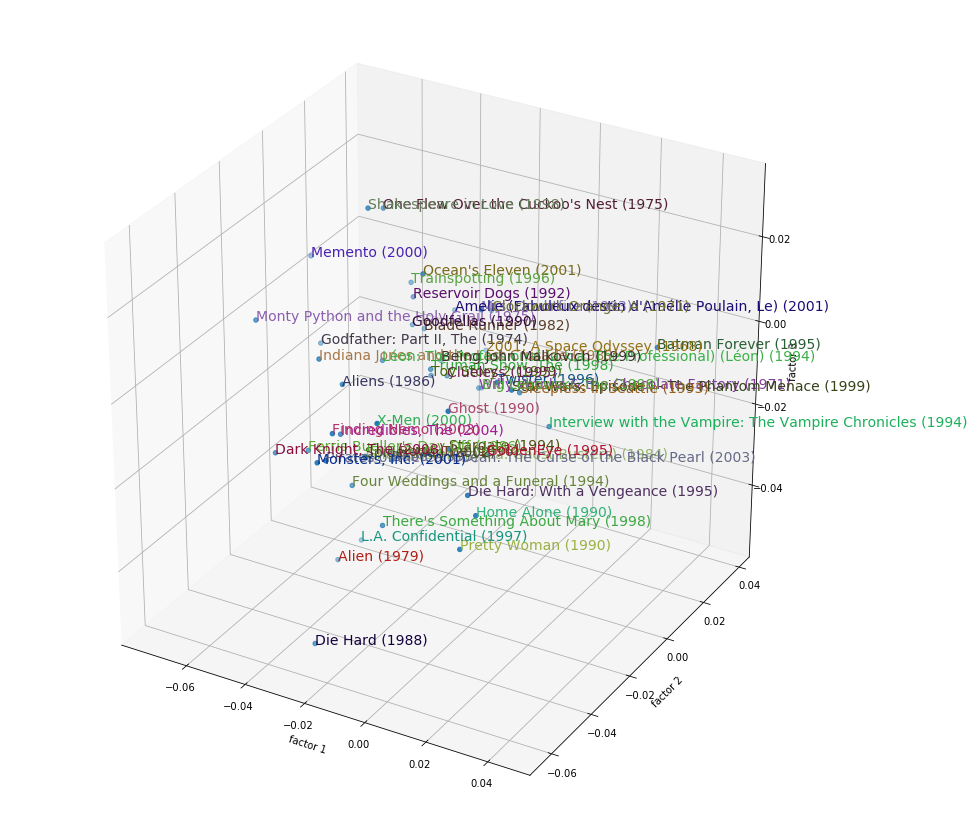

In [56]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

start=50; end=100
x_axis = fact1[start:end]
y_axis = fact2[start:end]
from mpl_toolkits.mplot3d import Axes3D

z_axis = fact3[start:end]
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_axis, y_axis, z_axis)
ax.set_xlabel('factor 1')
ax.set_ylabel('factor 2')
ax.set_zlabel('factor 3')
for i,x,y,z in zip(topMovies[start:end], x_axis, y_axis, z_axis):
    ax.text(x,y,z,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()


Well, the 3D plot is not user friendly, if it was drawn into a separate windows not inline, it would have been easier to look at , as we could have easily rottated it around. Let's just plot 2 factors.

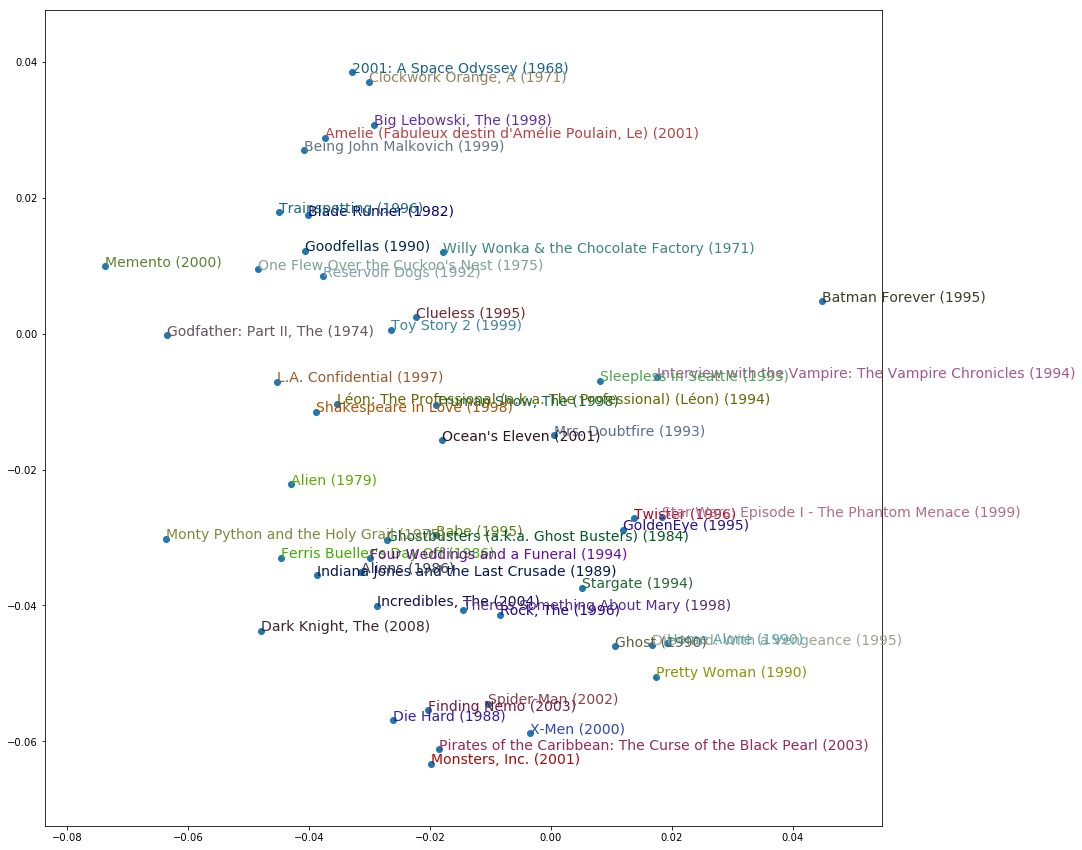

In [60]:
plt.figure(figsize=(15,15))
plt.scatter(x_axis, y_axis)
for i,x,y in zip(topMovies[start:end], x_axis, y_axis):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

#### Thanks for going through this notebook, I hope it was helpful.

##### Regards,
##### Abdelrahman Matar